<img src="https://github.com/AmsterdamUMC/AmsterdamUMCdb/blob/master/img/logo_c4i_square.png?raw=1" alt="Logo C4I" width=128px/>

<img src="https://github.com/AmsterdamUMC/AmsterdamUMCdb/blob/master/img/logo_amds.png?raw=1" alt="Logo AMDS" width=128px/>

# AmsterdamUMCdb with Google BigQuery and Colaboratory
## AmsterdamUMCdb - Freely Accessible ICU Database

AmsterdamUMCdb version 1.5.0 May 2024  
Copyright &copy; 2003-2024 Amsterdam UMC - Amsterdam Medical Data Science

# Introduction
To encourage rapid data exploration and model development, access to AmsterdamUMCdb is also available using Google BigQuery with Google Colaboratory ('Colab') as the main coding environment. This removes the necessity of downloading the AmsterdamUMCdb csv files, setting up a database system and installing a coding environment.

Recently, AmsterdamUMCdb has been [converted](https://github.com/AmsterdamUMC/AMSTEL) to the [Observational Medical Outcomes Partnership Common Data Model version 5.4](https://ohdsi.github.io/CommonDataModel/cdm54.html) (OMOP CDM 5.4) maintained by the [Observational Health Data Sciences and Informatics](https://www.ohdsi.org/) (OHDSI) community. The transition from the original ('classic') AmsterdamUMCdb data format to the OMOP CDM should improve the reusability of both the data and analyses on the current and future version of database by closely adhering to the [FAIR](https://doi.org/10.1038/sdata.2016.18) (Findable, Accessible, Interoperable and Reusable) principles.

This tutorial for using AmsterdamUMCdb on BigQuery was based on the original Google BigQuery tutorial on [Colab](https://colab.research.google.com/notebooks/bigquery.ipynb).

# Running Colab
If not done already, please open Colab with this **getting_started** notebook from the official AmsterdamUMCdb GitHub repository: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AmsterdamUMC/AmsterdamUMCdb/blob/master/bigquery/getting_started.ipynb)

**Important**: when following this tutorial, make sure to follow *all* steps and to run the **code cells** using the **Play** button or by pressing `Ctrl-Enter`

# Before you Begin
Ensure you have a working Google account and verify that the e-mail address used when applying for access has been associated with this account. If you already have a Google account, you can add secondary e-mail addresses [here](https://myaccount.google.com/alternateemail), or alternatively create another Google account using the e-mail address used in the application form.

If you don't have any experience in using Jupyter notebooks and/or Python, it is recommended to familiarize yourself with the [basics](https://colab.research.google.com/notebooks/intro.ipynb).

# Accessing the database
Provided you have signed the end user license agreement, you will have free access to the data from AmsterdamUMCdb through the Google Cloud Platform.

To explore and query the database you need to create a Google Cloud Platform project. For new users, Google offers a free tier of 1 TB (2<sup>40</sup> bytes) per month for queries and in addition \$300 credit for free for use on the Google Cloud Platform (currently: \$6.00 per TB). In the unlikely event, this amount is not sufficient during a datathon or course, please contact us and we will work with you to find a solution.

# Signing up for Google Cloud Platform
- To sign up for the free tier and free credits, please visit the Google Cloud Platform: https://cloud.google.com/.
- Click **Get started for free**.
- Log in with the Google account you used when registering for the datathon.
- In Step 1 of 2: agree to the **Terms of Service** and select **Continue**.
- In Step 2 of 2: You will be required to add some additional information, including a payment method to make sure you are not a robot. Don't worry you won't be charged unless you manually upgrade to a paid account. Depending on your payment provider, you may have an additional step to verify the payment method.
- Finally press **Start my free trial**. You are good to go.



<a name="cell-project-id"></a>
# Retrieving your Google Cloud Project ID
- At the top of the screen, select **My First Project** or [create a new one](https://console.cloud.google.com/projectcreate). Please write down the Project ID in the cell below ("Insert text here") and **Run** the cell to store the value.

In [1]:
# sets *your* project id
PROJECT_ID = "project-b94b02e0-ce53-4cd7-9a8" #@param {type:"string"}

# Sets the default BigQuery dataset for accessing AmsterdamUMCdb

If you have received instructions to use a specific BigQuery instance, change the default settings here. Otherwise use these default values.

In [2]:
# sets default dataset for AmsterdamUMCdb
DATASET_PROJECT_ID = 'amsterdamumcdb' #@param {type:"string"}
DATASET_ID = 'van_gogh_2026_datathon' #@param {type:"string"}
LOCATION = 'eu' #@param {type:"string"}

# Provide your credentials to access the AmsterdamUMCdb dataset on Google BigQuery
Authenticate your credentials with Google Cloud Platform and set your default Google Cloud Project ID as an environment variable for running query jobs.

1. Run the cell. The `Allow this notebook to access your Google credentials?` prompt appears. Select `Allow`.
2. In the `Sign in - Google Accounts` dialog, use the account you registered during the AmsterdamUMCdb application process and select `Allow` again.

In [3]:
import os
from google.colab import auth

# all libraries check this environment variable, so set it:
os.environ["GOOGLE_CLOUD_PROJECT"] = PROJECT_ID

auth.authenticate_user()
print('Authenticated')

Authenticated


# Google BigQuery costs
Since BiqQuery uses a [columnar data structure](https://en.wikipedia.org/wiki/Column-oriented_DBMS), Google will charge you according to the columns selected and the size of the data in those columns. Especially in the data exploration phase, it is prudent to query only the columns you will be actually needing for the analysis.

To help reduce costs, the largest tables that contain device generated data, have been [partitioned](https://cloud.google.com/bigquery/docs/partitioned-tables) by `provider_id`. Unvalidated data (`provider_id IS NULL`) that has been filed up to every minute throughout the ICU stay has been stored in a separate partition. To protect against excessive costs, you are required to specifiy a `WHERE provider_id` clause when accessing these tables.

In addition, the tables have also been [clustered](https://cloud.google.com/bigquery/docs/clustered-tables) on `<domain>_concept_id`, `person_id`, and `<domain>_datetime`. By filtering using WHERE on these columns (in the above order), you can reduce the processing costs as well.

Some examples:

`SELECT * FROM measurements WHERE NOT provider_id IS NULL` will process about 11 GiB data, whereas

`SELECT person_id, visit_occurrence_id, measurement_concept_id, measurement_datetime, value_as_number, unit_concept_id FROM measurement WHERE NOT provider_id IS NULL` will process around 5.5 GiB.

**Important**: `LIMIT` or `WHERE` clauses on columns that have not been used in partitioning or clustering of the data do not have **any** effect on reducing the amount of data processed, and thus charged. These clauses will only limit the number of records returned by the query.

# Available documentation for AmsterdamUMCdb tables.
Since the migration to the OMOP Common Data Model, the official documentation for all tables can be found [here](https://ohdsi.github.io/CommonDataModel/cdm54.html).

# Enable data table display

Colab includes the `google.colab.data_table` package that can be used to display Pandas dataframes as an interactive data table (default limits: `max_rows = 20000`, `max_columns = 20`). This is especially useful when exploring the  tables or dictionary from AmsterdamUMCdb. It can be enabled with:

In [4]:
%load_ext google.colab.data_table
from google.colab.data_table import DataTable

# change default limits:
DataTable.max_columns = 50
DataTable.max_rows = 30000

# Running your first query on AmsterdamUMCdb
BigQuery provides different ways to query the dataset:
- **magics**: the `bigquery_magics` library includes a `%%bigquery` *magic* command which runs a query and either displays the result or saves it to a Pandas DataFrame. The main advantage of this technique is that it improves readability of SQL code by syntax highlighting. Its main limitation: it requires a separate cell for the query, so cannot be combined with other Python code in the same code cell.

Let's query the `person` table using magics.



## Set the default query job configuration for magics

In [45]:
%load_ext bigquery_magics
from bigquery_magics import bigquery_magics
from google.cloud import bigquery

# sets the default query job configuration
def_config = bigquery.job.QueryJobConfig(default_dataset=DATASET_PROJECT_ID + "." + DATASET_ID)
bigquery_magics.context.default_query_job_config = def_config

The bigquery_magics extension is already loaded. To reload it, use:
  %reload_ext bigquery_magics


## Query the `person` table and copy the data to the `persons` Pandas dataframe:

The `person` table contains a record for each patient in AmsterdamUMCdb.

Since this is a relatively small table, it is acceptable to use `SELECT *`.

**Note**: Should an error occur while running the query, please see
the AmsterdamUMCdb BigQuery [Frequently Asked Questions](https://github.com/AmsterdamUMC/AmsterdamUMCdb/wiki/bigquery#faq).

In [46]:
%%bigquery person
SELECT * FROM person

Query is running:   0%|          |

Downloading:   0%|          |

In [52]:
%%bigquery tables_list
SELECT table_name
FROM `amsterdamumcdb.van_gogh_2026_datathon.INFORMATION_SCHEMA.TABLES`
ORDER BY table_name

Query is running:   0%|          |

Downloading:   0%|          |

In [55]:
%%bigquery df_tables
SELECT table_name
FROM `amsterdamumcdb.van_gogh_2026_datathon.INFORMATION_SCHEMA.TABLES`
ORDER BY table_name

Query is running:   0%|          |

Downloading:   0%|          |

In [56]:
df_tables

table_name
0                concept
1       concept_ancestor
2          concept_class
3   concept_relationship
4        concept_synonym
5   condition_occurrence
6                  death
7        device_exposure
8                 domain
9          drug_exposure
10         drug_strength
11           measurement
12           observation
13                person
14          relationship
15      visit_occurrence
16            vocabulary

In [64]:
%%bigquery measurement_df
SELECT *
FROM measurement
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

In [67]:
measurement_df

person_id  measurement_concept_id measurement_date  \
0      57647                 1175625       2010-01-02   
1      57647                 1175625       2010-01-02   
2      62050                 1175625       2017-01-02   
3      62393                 1175625       2017-01-15   
4      58323                 1175625       2017-01-15   
5      61071                 1175625       2000-08-16   
6      60152                 1175625       2001-12-31   
7      58191                 1175625       2002-01-01   
8      61268                 1175625       2002-01-01   
9      57212                 1175625       2002-01-01   

       measurement_datetime  measurement_type_concept_id  value_as_number  \
0 2010-01-02 21:50:00+00:00                            0              NaN   
1 2010-01-02 22:50:00+00:00                            0              NaN   
2 2017-01-02 08:52:00+00:00                            0              NaN   
3 2017-01-15 21:38:00+00:00                            0              NaN   
4 2017-01-15 22:23:00+00:00                            0              NaN   
5 2000-08-16 22:05:00+00:00                            0              0.0   
6 2001-12-31 21:44:00+00:00                            0              0.0   
7 2002-01-01 00:00:00+00:00                            0              0.0   
8 2002-01-01 00:02:00+00:00                            0              0.0   
9 2002-01-01 00:02:00+00:00                            0              0.0   

                            measurement_source_value unit_source_value  \
0  AF spont ;R UMCA ICU VENTILATOR RESPIRATORY RA...            br/min   
1  AF spont ;R UMCA ICU VENTILATOR RESPIRATORY RA...            br/min   
2  AF spont ;R UMCA ICU VENTILATOR RESPIRATORY RA...            br/min   
3  AF spont ;R UMCA ICU VENTILATOR RESPIRATORY RA...            br/min   
4  AF spont ;R UMCA ICU VENTILATOR RESPIRATORY RA...            br/min   
5                 Ademfrequentie Spontaan (bewaking)               bpm   
6                 Ademfrequentie Spontaan (bewaking)               bpm   
7                 Ademfrequentie Spontaan (bewaking)               bpm   
8                 Ademfrequentie Spontaan (bewaking)               bpm   
9                 Ademfrequentie Spontaan (bewaking)               bpm   

  value_source_value  
0               None  
1               None  
2               None  
3               None  
4               None  
5                0.0  
6                0.0  
7                0.0  
8                0.0  
9                0.0

In [76]:
%%bigquery top_measurements
SELECT
    c.concept_name,
    m.measurement_concept_id,
    COUNT(*) as count_records
FROM
    measurement m
JOIN
    concept c ON m.measurement_concept_id = c.concept_id
GROUP BY
    c.concept_name, m.measurement_concept_id
ORDER BY
    count_records DESC
LIMIT 30

Query is running:   0%|          |

Downloading:   0%|          |

In [77]:
top_measurements

concept_name  measurement_concept_id  \
0                                        ST deviation                 3017453   
1                        Invasive Mean blood pressure                21490852   
2                                        fio2 setting              2000000204   
3   Oxygen saturation in Arterial blood by Pulse o...                40762499   
4                                    Respiratory rate                 3024171   
5                 Fluid intake intravascular Measured                 3037253   
6                        Heart rate by Pulse oximetry                 3001376   
7   Carbon dioxide [Partial pressure] in Exhaled g...                 3035357   
8   Positive end expiratory pressure setting Venti...                 3022875   
9                      Heart rate.beat-to-beat by EKG                21490872   
10                   Invasive Systolic blood pressure                21490853   
11                               Mean airway pressure                42527086   
12                              Tidal volume.inspired                36303816   
13                  Invasive Diastolic blood pressure                21490851   
14       Volume expired per minute Respiratory system                21490753   
15                    Tidal volume setting Ventilator                 3012410   
16                Vent mechanics peak airway pressure              2000000238   
17                                    Lung compliance                21490581   
18                     Breath rate setting Ventilator                 3007469   
19     Tidal volume expired Respiratory system airway                21490752   
20          Heart rate Peripheral artery by palpation                 3003841   
21                                   Body temperature                 3020891   
22         Pressure.plateau Respiratory system airway                36304439   
23                    Inspiratory Pressure Above PEEP              2000000211   
24                Inspiratory time setting Ventilator                36304672   
25                                expiratory time sec              2000000199   
26                                         Heart rate                 3027018   
27                            Breath rate spontaneous                 1175625   
28  Pressure.max Respiratory system airway --on ve...                36306157   
29                                  Airway resistance                21490740   

    count_records  
0        31932344  
1        17383466  
2        15506049  
3        15126034  
4        14201192  
5        14090784  
6        14081859  
7        11131232  
8        10425042  
9         9614876  
10        8905484  
11        8812521  
12        8051473  
13        7175006  
14        7136261  
15        5818150  
16        5796940  
17        5767196  
18        5711113  
19        5575137  
20        5561559  
21        5264202  
22        5135999  
23        5102095  
24        5057597  
25        4761751  
26        4565653  
27        4469710  
28        3848310  
29        3785229

In [71]:
%%bigquery vent_concepts
SELECT
    c.concept_id,
    c.concept_name,
    COUNT(*) as records_found
FROM
    `measurement` m
JOIN
    `concept` c ON m.measurement_concept_id = c.concept_id
WHERE
    LOWER(c.concept_name) LIKE '%peep%'
    OR LOWER(c.concept_name) LIKE '%tidal volume%'
    OR LOWER(c.concept_name) LIKE '%fio2%'
    OR LOWER(c.concept_name) LIKE '%inspiratory pressure%'
GROUP BY
    c.concept_id, c.concept_name
ORDER BY
    records_found DESC
LIMIT 20

Query is running:   0%|          |

Downloading:   0%|          |

In [72]:
vent_concepts

concept_id                                       concept_name  \
0   2000000204                                       fio2 setting   
1     36303816                              Tidal volume.inspired   
2      3012410                    Tidal volume setting Ventilator   
3     21490752     Tidal volume expired Respiratory system airway   
4   2000000211                    Inspiratory Pressure Above PEEP   
5      3016226                            PEEP Respiratory system   
6   2000000209                Inspiratory Pressure Above PEEP Set   
7      3035822                  Intrinsic PEEP Respiratory system   
8     42527140                      Total PEEP Respiratory system   
9      3017594           Tidal volume.spontaneous --on ventilator   
10    21490854            Tidal volume Ventilator --on ventilator   
11  2000000205                                 fio2 --placeholder   
12  2000000101                                          ECMO FiO2   
13     3017878  Tidal volume.spontaneous+mechanical/Body weigh...   
14  2000000203                                fio2 --non-invasive   
15  2000000190                     bipap inspiratory pressure set   
16  2000000210           Inspiratory Pressure Above PEEP Measured   
17  2000000239                       Vent mechanis paw total peep   
18  2000000214                               Inspiratory Pressure   

    records_found  
0        15506049  
1         8051473  
2         5818150  
3         5575137  
4         5102095  
5         3208912  
6         3113240  
7         2916879  
8         1667756  
9          641549  
10         236013  
11         130575  
12          21917  
13           1534  
14            942  
15            392  
16            310  
17            190  
18            188

In [73]:
%%bigquery resolution_check
SELECT
    person_id,
    measurement_datetime,
    value_as_number as FiO2_Setting,
    -- Calculate time difference from the previous row
    TIMESTAMP_DIFF(
        measurement_datetime,
        LAG(measurement_datetime) OVER (PARTITION BY person_id ORDER BY measurement_datetime),
        MINUTE
    ) as minutes_since_last_reading
FROM
    `measurement`
WHERE
    measurement_concept_id = 2000000204 -- FiO2 Setting
    AND value_as_number IS NOT NULL
-- Get data for just one patient to keep it readable
LIMIT 20

Query is running:   0%|          |

Downloading:   0%|          |

In [74]:
resolution_check

person_id      measurement_datetime  FiO2_Setting  \
0         193 2002-01-01 00:20:00+00:00     39.599998   
1         193 2002-01-01 00:20:00+00:00     40.000000   
2         193 2002-01-01 00:31:00+00:00     49.599998   
3         193 2002-01-01 00:31:00+00:00     50.000000   
4         193 2002-01-01 01:31:00+00:00     49.400002   
5         193 2002-01-01 01:31:00+00:00     50.000000   
6         193 2002-01-01 02:31:00+00:00     49.500000   
7         193 2002-01-01 02:31:00+00:00     50.000000   
8         193 2002-01-01 03:31:00+00:00     49.799999   
9         193 2002-01-01 03:31:00+00:00     50.000000   
10        193 2002-01-01 04:31:00+00:00     49.599998   
11        193 2002-01-01 04:31:00+00:00     50.000000   
12        193 2002-01-01 05:31:00+00:00     49.900002   
13        193 2002-01-01 05:31:00+00:00     50.000000   
14        193 2002-01-01 06:31:00+00:00     49.700001   
15        193 2002-01-01 06:31:00+00:00     50.000000   
16        193 2002-01-01 11:13:00+00:00     33.900002   
17        193 2002-01-01 11:13:00+00:00     50.000000   
18        193 2002-01-01 11:31:00+00:00     49.900002   
19        193 2002-01-01 11:31:00+00:00     50.000000   

    minutes_since_last_reading  
0                         <NA>  
1                            0  
2                           11  
3                            0  
4                           60  
5                            0  
6                           60  
7                            0  
8                           60  
9                            0  
10                          60  
11                           0  
12                          60  
13                           0  
14                          60  
15                           0  
16                         282  
17                           0  
18                          18  
19                           0

In [78]:
%%bigquery patient_matrix
SELECT
    person_id,
    -- Truncate time to the hour to align different sensors
    TIMESTAMP_TRUNC(measurement_datetime, HOUR) as time_hour,

    -- Hemodynamics
    AVG(CASE WHEN measurement_concept_id = 3001376 THEN value_as_number END) as Heart_Rate,
    AVG(CASE WHEN measurement_concept_id = 21490852 THEN value_as_number END) as Invasive_MAP,
    AVG(CASE WHEN measurement_concept_id = 40762499 THEN value_as_number END) as SpO2,

    -- Ventilation
    AVG(CASE WHEN measurement_concept_id = 2000000204 THEN value_as_number END) as FiO2,
    AVG(CASE WHEN measurement_concept_id = 3022875 THEN value_as_number END) as PEEP,
    AVG(CASE WHEN measurement_concept_id = 36303816 THEN value_as_number END) as Tidal_Volume,
    AVG(CASE WHEN measurement_concept_id = 21490581 THEN value_as_number END) as Compliance

FROM
    `measurement`
WHERE
    person_id = 193 -- Example Patient (Replace with others to test)
    AND measurement_concept_id IN (
        3001376, 21490852, 40762499, -- HR, MAP, SpO2
        2000000204, 3022875, 36303816, 21490581 -- FiO2, PEEP, TV, Compliance
    )
GROUP BY
    person_id, time_hour
ORDER BY
    time_hour

Query is running:   0%|          |

Downloading:   0%|          |

In [79]:
patient_matrix

person_id                 time_hour  Heart_Rate  Invasive_MAP  SpO2  \
0         193 2002-01-01 00:00:00+00:00         NaN     87.500018   NaN   
1         193 2002-01-01 01:00:00+00:00         NaN     74.999999   NaN   
2         193 2002-01-01 02:00:00+00:00         NaN     79.000017   NaN   
3         193 2002-01-01 03:00:00+00:00         NaN     73.000000   NaN   
4         193 2002-01-01 04:00:00+00:00         NaN     73.000000   NaN   
5         193 2002-01-01 05:00:00+00:00         NaN     83.000021   NaN   
6         193 2002-01-01 06:00:00+00:00         NaN     77.500007   NaN   
7         193 2002-01-01 07:00:00+00:00         NaN     74.999999   NaN   
8         193 2002-01-01 08:00:00+00:00         NaN     80.999986   NaN   
9         193 2002-01-01 09:00:00+00:00         NaN     73.000000   NaN   
10        193 2002-01-01 10:00:00+00:00         NaN     84.000006   NaN   
11        193 2002-01-01 11:00:00+00:00         NaN     73.999999   NaN   
12        193 2002-01-01 12:00:00+00:00         NaN     88.000010   NaN   
13        193 2002-01-01 13:00:00+00:00         NaN     84.999991   NaN   
14        193 2002-01-01 14:00:00+00:00         NaN     63.000001   NaN   
15        193 2002-01-01 15:00:00+00:00         NaN     59.000000   NaN   
16        193 2002-01-01 16:00:00+00:00         NaN     69.000003   NaN   
17        193 2002-01-01 17:00:00+00:00         NaN     79.000017   NaN   
18        193 2002-01-01 18:00:00+00:00         NaN     70.000003   NaN   
19        193 2002-01-01 19:00:00+00:00         NaN     89.999972   NaN   
20        193 2002-01-01 20:00:00+00:00         NaN     83.000021   NaN   
21        193 2002-01-01 22:00:00+00:00         NaN     76.499997   NaN   

         FiO2  PEEP  Tidal_Volume  Compliance  
0   44.799999   5.0         260.0         NaN  
1   49.700001   5.0         375.0         NaN  
2   49.750000   5.0         317.0         NaN  
3   49.900000   5.0        1373.0         NaN  
4   49.799999   5.0         550.0         NaN  
5   49.950001   5.0         982.0         NaN  
6   49.850000   5.0         764.0         NaN  
7         NaN   NaN           NaN         NaN  
8         NaN   NaN           NaN         NaN  
9         NaN   NaN           NaN         NaN  
10        NaN   NaN           NaN         NaN  
11  45.950001   6.5         496.5         NaN  
12  69.799999  10.0         123.0         NaN  
13  69.799999  10.0         360.0         NaN  
14  69.849998  10.0         241.0         NaN  
15  69.750000  10.0         386.0         NaN  
16  69.700001  10.0         170.0         NaN  
17  69.700001  10.0         426.0         NaN  
18  69.599998  10.0         216.0         NaN  
19  69.450001  10.0         268.0         NaN  
20  69.299999  10.0         243.0         NaN  
21        NaN   NaN           NaN         NaN

In [80]:
%%bigquery patient_count
SELECT
    COUNT(DISTINCT person_id) as number_of_unique_patients
FROM
    `person`

Query is running:   0%|          |

Downloading:   0%|          |

In [81]:
patient_count

number_of_unique_patients
0                      65397

In [82]:
%%bigquery counts_comparison
SELECT
    COUNT(DISTINCT p.person_id) as unique_patients,
    COUNT(DISTINCT v.visit_occurrence_id) as total_admissions,

    -- Calculate the average number of admissions per patient
    COUNT(DISTINCT v.visit_occurrence_id) / COUNT(DISTINCT p.person_id) as avg_admissions_per_patient
FROM
    `person` p
JOIN
    `visit_occurrence` v ON p.person_id = v.person_id

Query is running:   0%|          |

Downloading:   0%|          |

In [83]:
counts_comparison

unique_patients  total_admissions  avg_admissions_per_patient
0            65397             79838                    1.220821

In [84]:
%%bigquery outcomes_df
SELECT
    COUNT(DISTINCT v.visit_occurrence_id) as total_admissions,

    -- 1. Calculate Mortality Rate
    -- We check if there is a matching record in the DEATH table
    COUNT(DISTINCT d.person_id) as total_deaths,
    ROUND(COUNT(DISTINCT d.person_id) / COUNT(DISTINCT p.person_id) * 100, 2) as mortality_rate_percent,

    -- 2. Calculate Length of Stay (LOS) in Days
    ROUND(AVG(TIMESTAMP_DIFF(v.visit_end_datetime, v.visit_start_datetime, HOUR) / 24.0), 1) as avg_los_days,

    -- Median is often better for LOS because of long-stay outliers
    -- BigQuery APPROX_QUANTILES is the fastest way to get median
    ROUND(APPROX_QUANTILES(TIMESTAMP_DIFF(v.visit_end_datetime, v.visit_start_datetime, HOUR) / 24.0, 100)[OFFSET(50)], 1) as median_los_days

FROM
    `visit_occurrence` v
JOIN
    `person` p ON v.person_id = p.person_id
LEFT JOIN
    `death` d ON p.person_id = d.person_id

Query is running:   0%|          |

Downloading:   0%|          |

In [85]:
outcomes_df

total_admissions  total_deaths  mortality_rate_percent  avg_los_days  \
0             79838         11413                   17.45           4.2   

   median_los_days  
0              1.5

In [86]:
%%bigquery demographics_df
SELECT
    p.person_id,
    v.visit_occurrence_id,

    -- 1. Get Gender Name (Join with Concept table)
    c.concept_name as gender,

    -- 2. Calculate Age at Admission
    -- (Visit Year - Birth Year)
    (EXTRACT(YEAR FROM v.visit_start_date) - p.year_of_birth) as age_at_admission,

    -- 3. Mortality Status (for grouping)
    CASE WHEN d.death_date IS NOT NULL THEN 'Expired' ELSE 'Survived' END as outcome

FROM
    `person` p
JOIN
    `visit_occurrence` v ON p.person_id = v.person_id
LEFT JOIN
    `concept` c ON p.gender_concept_id = c.concept_id
LEFT JOIN
    `death` d ON p.person_id = d.person_id
WHERE
    -- Filter out data errors where age might be negative or impossible
    (EXTRACT(YEAR FROM v.visit_start_date) - p.year_of_birth) BETWEEN 18 AND 110

Query is running:   0%|          |

Downloading:   0%|          |

In [87]:
demographics_df

person_id  visit_occurrence_id gender  age_at_admission   outcome
0          20969                64791   MALE                85  Survived
1          20969                 4400   MALE                85  Survived
2           9656                61314   MALE                85  Survived
3          38388                69305   MALE                85  Survived
4          39876                69799   MALE                85   Expired
...          ...                  ...    ...               ...       ...
83388      54799                75126   None                29  Survived
83389      58228                31297   None                29  Survived
83390      58228                 8223   None                29  Survived
83391      21496                30471   None                29  Survived
83392       8924                 5028   None                29  Survived

[83393 rows x 5 columns]

   person_id  visit_occurrence_id gender  age_at_admission   outcome
0      20969                64791   MALE                85  Survived
1      20969                 4400   MALE                85  Survived
2       9656                61314   MALE                85  Survived
3      38388                69305   MALE                85  Survived
4      39876                69799   MALE                85   Expired


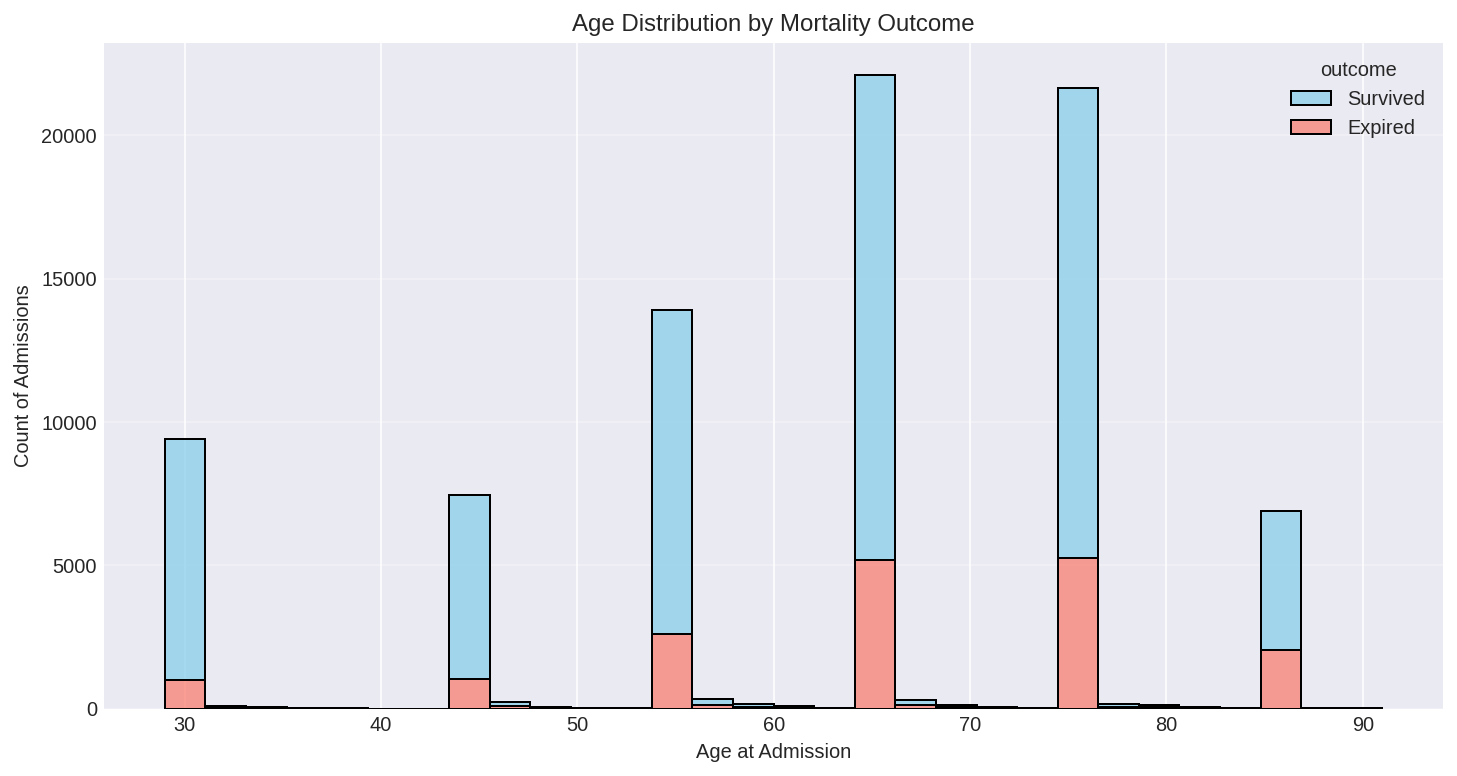


Summary Statistics:
            count       mean        std   min   25%   50%   75%   max
outcome                                                              
Expired   17838.0  65.493889  13.875783  29.0  55.0  65.0  75.0  91.0
Survived  65555.0  60.587324  16.183525  29.0  55.0  65.0  75.0  91.0


In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

# Check the first few rows
print(demographics_df.head())

# Set up the plot
plt.figure(figsize=(12, 6))

# Create a histogram of Age, colored by Outcome (Survived vs Expired)
sns.histplot(
    data=demographics_df,
    x='age_at_admission',
    hue='outcome',
    multiple='stack',
    bins=30,
    palette={'Survived': 'skyblue', 'Expired': 'salmon'}
)

plt.title('Age Distribution by Mortality Outcome')
plt.xlabel('Age at Admission')
plt.ylabel('Count of Admissions')
plt.grid(axis='y', alpha=0.3)
plt.show()

# Print summary stats
print("\nSummary Statistics:")
print(demographics_df.groupby('outcome')['age_at_admission'].describe())

## Display the `person` dataframe.

In [62]:
person

person_id  gender_concept_id  year_of_birth  month_of_birth  \
0          16819               <NA>           1917               1   
1          26082               <NA>           1917               1   
2          10193               <NA>           1917               1   
3          35113               <NA>           1917               1   
4           3703               <NA>           1917               1   
...          ...                ...            ...             ...   
65392      53492               8532           1988               1   
65393      64874               8532           1988               1   
65394        278               8532           1988               1   
65395      12099               8532           1988               1   
65396      62507               8532           1988               1   

       day_of_birth            birth_datetime  race_concept_id  
0                 1 1917-01-01 00:00:00+00:00                0  
1                 1 1917-01-01 00:00:00+00:00                0  
2                 1 1917-01-01 00:00:00+00:00                0  
3                 1 1917-01-01 00:00:00+00:00                0  
4                 1 1917-01-01 00:00:00+00:00                0  
...             ...                       ...              ...  
65392             1 1988-01-01 00:00:00+00:00                0  
65393             1 1988-01-01 00:00:00+00:00                0  
65394             1 1988-01-01 00:00:00+00:00                0  
65395             1 1988-01-01 00:00:00+00:00                0  
65396             1 1988-01-01 00:00:00+00:00                0  

[65397 rows x 7 columns]

In [63]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=person)

https://docs.google.com/spreadsheets/d/1bZguXQmvIjCx3gXt7B6NxhCNAkEf9W7oR7x7Ivc4t_I/edit#gid=0


# Query AmsterdamUMCdb through google-cloud-bigquery

Alternatively, we can manually invoke the `biqquery` Python module. The following examples re-use the previously entered `PROJECT_ID` from [Retrieving your Google Cloud Project ID](#cell-project-id). For more information, see [BigQuery documentation](https://cloud.google.com/bigquery/docs) and [library reference documentation](https://googleapis.dev/python/bigquery/latest/index.html).


## Set the default query job configuration for google-cloud-bigquery client

In [28]:
from google.cloud import bigquery

# BigQuery requires a separate config to prevent the 'BadRequest: 400 Cannot explicitly modify anonymous table' error message
job_config = bigquery.job.QueryJobConfig()

# sets default client settings by re-using the previously defined config
client = bigquery.Client(project=PROJECT_ID, location=LOCATION, default_query_job_config=def_config)

## Get all patients and group by year of birth

In [29]:
year_of_birth = client.query(
    '''
    SELECT
      year_of_birth
      , COUNT(*) AS number_of_admissions -- COUNT(*) counts everything including NULL
    FROM person
    GROUP BY year_of_birth
    ORDER BY year_of_birth ASC
    '''
    , job_config=job_config).to_dataframe()

year_of_birth

year_of_birth  number_of_admissions
0            1917                  1550
1            1925                  2559
2            1927                  4642
3            1932                  1758
4            1935                  6568
5            1937                  4383
6            1942                  6035
7            1945                  7016
8            1947                  3070
9            1952                  5770
10           1955                  4498
11           1957                  1733
12           1962                  3651
13           1965                  2665
14           1972                  1753
15           1973                  1963
16           1981                  3233
17           1988                  2550

## Show a plot
Uses the Pandas built-in functions to plot a bar chart.

<Axes: xlabel='year_of_birth'>

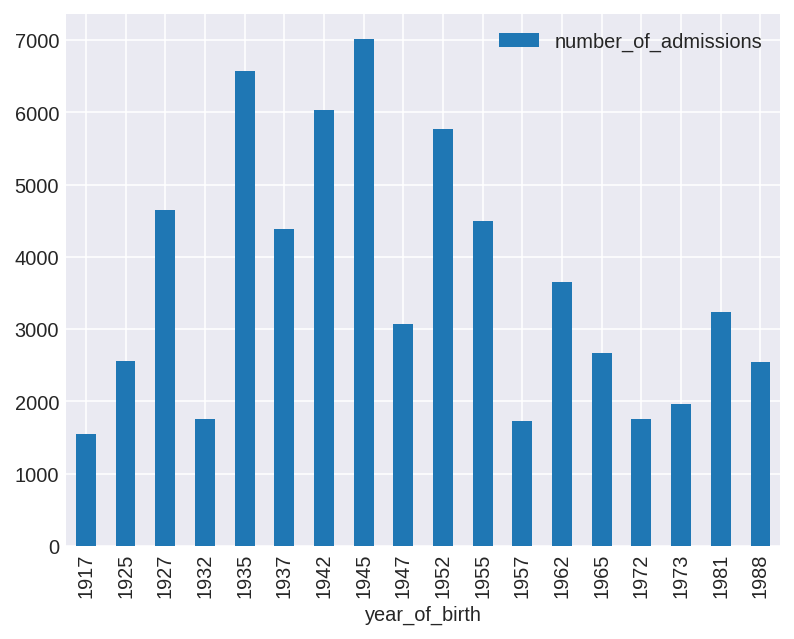

In [30]:
# modifies the pyplot back-end of Pandas to increase render resolution
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams["figure.dpi"] = 144

year_of_birth.plot(kind='bar', x='year_of_birth')

# Visit_occurrence
This table stores information about the ICU admissions. Patients (`person`) can have multiple visit_occurrence records.

This table is very similar to the legacy `admissions` table.

In [31]:
visit_occurrence = client.query(
    '''
    SELECT *
    FROM visit_occurrence
    '''
    , job_config=job_config).to_dataframe()

visit_occurrence

visit_occurrence_id  person_id  visit_concept_id visit_start_date  \
0                    38018      60705              9201       2002-01-01   
1                    26812       6336              9201       2002-01-01   
2                    72441      32512              9201       2002-01-01   
3                    70071      10206              9201       2002-01-01   
4                    31479      47522              9201       2002-01-01   
...                    ...        ...               ...              ...   
79833                30390      50232              9201       2023-05-19   
79834                73541      50232              9201       2023-06-01   
79835                66949      40798              9201       2023-07-07   
79836                49409      57957              9201       2023-08-27   
79837                32081      57957              9201       2023-08-31   

           visit_start_datetime visit_end_date        visit_end_datetime  \
0     2002-01-01 11:41:00+00:00            NaT                       NaT   
1     2002-01-01 00:00:00+00:00     2002-01-01 2002-01-01 00:01:00+00:00   
2     2002-01-01 00:00:00+00:00     2002-01-01 2002-01-01 00:01:00+00:00   
3     2002-01-01 00:00:00+00:00     2002-01-01 2002-01-01 00:01:00+00:00   
4     2002-01-01 00:00:00+00:00     2002-01-01 2002-01-01 00:01:00+00:00   
...                         ...            ...                       ...   
79833 2023-05-19 03:26:00+00:00     2023-05-19 2023-05-19 22:20:00+00:00   
79834 2023-06-01 10:01:00+00:00     2023-06-02 2023-06-02 22:34:00+00:00   
79835 2023-07-07 23:46:00+00:00     2023-07-09 2023-07-09 21:56:00+00:00   
79836 2023-08-27 02:03:00+00:00     2023-08-29 2023-08-29 19:45:00+00:00   
79837 2023-08-31 15:01:00+00:00     2023-09-05 2023-09-05 20:37:00+00:00   

       visit_type_concept_id visit_source_value  admitted_from_concept_id  \
0                      32827                icu                         0   
1                      32827                icu                         0   
2                      32827                icu                         0   
3                      32827                icu                         0   
4                      32827                icu                         0   
...                      ...                ...                       ...   
79833                  32827                icu                         0   
79834                  32827                icu                         0   
79835                  32827                icu                         0   
79836                  32827                icu                         0   
79837                  32827                icu                         0   

       discharged_to_concept_id admitted_from_source_value  \
0                             0                       None   
1                             0                       None   
2                             0                       None   
3                             0                       None   
4                             0                       None   
...                         ...                        ...   
79833                         0                       None   
79834                         0                       None   
79835                         0                       None   
79836                         0                       None   
79837                         0                       None   

      discharged_to_source_value  
0                           None  
1                           None  
2                           None  
3                           None  
4                           None  
...                          ...  
79833                       None  
79834                       None  
79835                       None  
79836                       None  
79837                       None  

[79838 rows x 13 columns]

In [32]:
provider = client.query(
    '''
    SELECT *
    FROM provider
    '''
    , job_config=job_config).to_dataframe()

provider

NotFound: 404 Not found: Table amsterdamumcdb:van_gogh_2026_datathon.provider was not found in location EU; reason: notFound, message: Not found: Table amsterdamumcdb:van_gogh_2026_datathon.provider was not found in location EU

Location: EU
Job ID: f5e889c6-1369-430a-b267-9eb250fd7be7


## Concept

In [ ]:
concept = client.query(
    '''
    SELECT *
    FROM concept
    WHERE concept_id = 38004497
    '''
    , job_config=job_config).to_dataframe()

concept

In [14]:
display(visit_occurrence.describe())

visit_occurrence_id     person_id  visit_concept_id  \
count              79838.0       79838.0           79838.0   
mean               39918.5  32680.038566            9201.0   
std           23047.389733  18880.089347               0.0   
min                    0.0           0.0            9201.0   
25%               19959.25       16294.0            9201.0   
50%                39918.5       32698.5            9201.0   
75%               59877.75      48998.75            9201.0   
max                79837.0       65396.0            9201.0   

       visit_type_concept_id  admitted_from_concept_id  \
count                79838.0                   79838.0   
mean                 32827.0                       0.0   
std                      0.0                       0.0   
min                  32827.0                       0.0   
25%                  32827.0                       0.0   
50%                  32827.0                       0.0   
75%                  32827.0                       0.0   
max                  32827.0                       0.0   

       discharged_to_concept_id  
count                   79838.0  
mean                        0.0  
std                         0.0  
min                         0.0  
25%                         0.0  
50%                         0.0  
75%                         0.0  
max                         0.0

In [15]:
display(visit_occurrence.columns)

Index(['visit_occurrence_id', 'person_id', 'visit_concept_id',
       'visit_start_date', 'visit_start_datetime', 'visit_end_date',
       'visit_end_datetime', 'visit_type_concept_id', 'visit_source_value',
       'admitted_from_concept_id', 'discharged_to_concept_id',
       'admitted_from_source_value', 'discharged_to_source_value'],
      dtype='object')

# Query AmsterdamUMCdb through pandas-gbq

The third option is to query the dataset using the Pandas `pandas-gbq` library. Especially when you are already familiar with the `pandas.read_sql` function, it's relatively straightforward to modify your existing code to be compatible with BigQuery. For more information, see [Pandas GBQ Documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_gbq.html).


**Note**: The `use_bqstorage_api=True` statement enables the Google Cloud BigQuery Storage API that improves the performance of copying data from BiqQuery to pandas DataFrames in the Colab environment (~around 16 times). While the usage of the Storage Read API is being charged separately, Google currently offers a free tier of 300 TB per month. However, you may choose to remove the option from the command.

## Set the default query job configuration for pandas-gbq

In [33]:
import pandas as pd

config_gbq = {'query':
          {'defaultDataset': {
              "datasetId": DATASET_ID,
              "projectId": DATASET_PROJECT_ID
              },
           'Location': LOCATION}
           }

## Retrieve the medical specialty associated with each admission

In [36]:
specialties = pd.read_gbq(
    '''
    SELECT concept_name AS specialty, COUNT(*) AS number_of_admissions
    FROM visit_occurrence v
    LEFT JOIN provider p ON p.provider_id = v.provider_id
    LEFT JOIN concept c ON c.concept_id = p.specialty_concept_id

    GROUP BY specialty
    ORDER BY number_of_admissions DESC
    '''
    , configuration=config_gbq, use_bqstorage_api=True)
specialties.plot(kind='bar', x='specialty')

/tmp/ipython-input-3199823195.py:1: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  specialties = pd.read_gbq(


GenericGBQException: Reason: 404 Not found: Table amsterdamumcdb:van_gogh_2026_datathon.provider was not found in location EU; reason: notFound, message: Not found: Table amsterdamumcdb:van_gogh_2026_datathon.provider was not found in location EU

Location: EU
Job ID: 73e8472a-e47a-4611-93a3-20e9f24597f4


# Getting the data you need
The `amsterdamumcdb` package provides the `get_dictionary()` function that returns a DataFrame containing all codes and (categorical) values ('concepts') of AmsterdamUMCdb. As part of the transformation to the OMOP Common Data Model, most concepts have been mapped to a Standard Concept in the [OMOP Standardized Vocabularies](https://ohdsi.github.io/TheBookOfOhdsi/StandardizedVocabularies.html).

The Standardized Vocabularies are a common respository for commonly used vocabularies such as [LOINC](https://decor.nictiz.nl/art-decor/loinc), [SNOMED CT](https://decor.nictiz.nl/art-decor/snomed-ct), [RxNorm](https://mor.nlm.nih.gov/RxNav/) and [ATC](https://www.whocc.no/atc_ddd_index/). The OMOP Standardized Vocabularies are available at [ATHENA](https://athena.ohdsi.org/search-terms/start).

**Note for users of the legacy (non-OMOP) versions (≤ 1.0.2) of AmsterdamUMCdb**

The original `itemid` is stored as `source_code` and `item` as `source_code_description` in the dictionary. To allow mapping of categorical values from the legacy `listitems` table to standard concepts, the `source_code` was generated using the format `{itemid}-{valueid}`. In addition, the `source_code` from the legacy `drugitems` was generated using the `{itemid}-{ordercategoryid}` format.

## Install the AmsterdamUMCdb package

In [19]:
# get the amsterdamumcdb package from PyPI repository for use in Colab
!pip install amsterdamumcdb
import amsterdamumcdb as adb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 552.5/552.5 kB 37.0 MB/s eta 0:00:00


## Load the AmsterdamUMCdb dictionary.
Use the **Filter** button to quickly browse through the dictionary.

In [20]:
dictionary = adb.get_dictionary()
dictionary = dictionary.convert_dtypes()
dictionary

concept_id                     concept_name    domain_id  \
0            8532                           FEMALE       Gender   
1            8507                             MALE       Gender   
2          581476                       Home Visit        Visit   
3          581383  Inpatient Cardiac Care Facility        Visit   
4            8870        Emergency Room - Hospital        Visit   
...           ...                              ...          ...   
13148    37079369              Supplemental result   Meas Value   
13149    36210399                    Not specified   Meas Value   
13150     4302933           Pleural fluid specimen     Specimen   
13151    45879739               No sample received   Meas Value   
13152     4104934        Incorrect sample received  Observation   

       concept_class_id         vocabulary_id concept_code  \
0                Gender                Gender            F   
1                Gender                Gender            M   
2                 Visit                 Visit  OMOP4822459   
3                 Visit  CMS Place of Service  OMOP4822038   
4                 Visit  CMS Place of Service           23   
...                 ...                   ...          ...   
13148            Answer                 LOINC    LA29938-0   
13149            Answer                 LOINC    LA27211-4   
13150          Specimen                SNOMED    418564007   
13151            Answer                 LOINC    LA12433-1   
13152  Clinical Finding                SNOMED    281267002   

       source_vocabulary_id                                source_code  \
0               AUMC Gender                                      Vrouw   
1               AUMC Gender                                        Man   
2               AUMC Origin                                       Huis   
3               AUMC Origin                   CCU/IC zelfde ziekenhuis   
4               AUMC Origin     Eerste Hulp afdeling zelfde ziekenhuis   
...                     ...                                        ...   
13148  AUMC Specimen Source                              11646-ZIE-OPM   
13149  AUMC Specimen Source                                    11646-0   
13150  AUMC Specimen Source                    11646-Vocht thoraxdrain   
13151  AUMC Specimen Source         11646-Niet afgenomen door afd/arts   
13152  AUMC Specimen Source  11646-Afname verkeerde buis door afd/arts   

                      source_code_description  value_of_concept_id  \
0                                       Vrouw                 <NA>   
1                                         Man                 <NA>   
2                                        Huis                 <NA>   
3                    CCU/IC zelfde ziekenhuis                 <NA>   
4      Eerste Hulp afdeling zelfde ziekenhuis                 <NA>   
...                                       ...                  ...   
13148                                 ZIE-OPM              3053213   
13149                                       0              3053213   
13150                       Vocht thoraxdrain              3053213   
13151            Niet afgenomen door afd/arts              3053213   
13152     Afname verkeerde buis door afd/arts              3053213   

       value_of_source_code  source_frequency  source_frequency_validated  \
0                      <NA>              7875                        7875   
1                      <NA>             14735                       14735   
2                      <NA>                85                          85   
3                      <NA>               296                         296   
4                      <NA>              2661                        2661   
...                     ...               ...                         ...   
13148                 11646               812                         812   
13149                 11646                 1                           1   
13150                 11646       

# Selecting relevant features


## Example: Lactate
Lactate, a laboratory measurement, can be found in the `measurement` table.

Since this is the largest table of AmsterdamUMCdb (188 GiB), it is highly recommended to correctly filter the query on:
- `provider_id` and
  - `measurement_concept_id` or
  - `measurement_concept_id`/`person_id` or
  - `measurement_concept_id`/`person_id`/`measurement_start_time`

### Get all lactate itemids

In [24]:
lactate_ids = dictionary[dictionary['concept_name'].str.contains(r'lactate', case=False)]
lactate_ids

concept_id                                       concept_name  \
1263    40709262  500 ML Calcium Chloride 0.268 MG/ML / Lactate ...   
5961    36878802                                  sodium dl-lactate   
5964    36878802                                  sodium dl-lactate   
7121     3016436  Lactate dehydrogenase [Enzymatic activity/volu...   
7125     3008338  Lactate dehydrogenase [Enzymatic activity/volu...   
7575     3008581  Lactate dehydrogenase [Enzymatic activity/volu...   
7583     3015054  Lactate dehydrogenase [Enzymatic activity/volu...   
7688     3047181                    Lactate [Moles/volume] in Blood   
8019     3014111          Lactate [Moles/volume] in Serum or Plasma   
8020     3016436  Lactate dehydrogenase [Enzymatic activity/volu...   
8077     3047181                    Lactate [Moles/volume] in Blood   

        domain_id  concept_class_id     vocabulary_id concept_code  \
1263         Drug  Marketed Product  RxNorm Extension  OMOP4747901   
5961         Drug        Ingredient  RxNorm Extension  OMOP1005620   
5964         Drug        Ingredient  RxNorm Extension  OMOP1005620   
7121  Measurement          Lab Test             LOINC       2532-0   
7125  Measurement          Lab Test             LOINC       2529-6   
7575  Measurement          Lab Test             LOINC       2531-2   
7583  Measurement          Lab Test             LOINC       2530-4   
7688  Measurement          Lab Test             LOINC      32693-4   
8019  Measurement          Lab Test             LOINC       2524-7   
8020  Measurement          Lab Test             LOINC       2532-0   
8077  Measurement          Lab Test             LOINC      32693-4   

     source_vocabulary_id source_code         source_code_description  \
1263            AUMC Drug     7316-55        Ri-Lac (Ringers lactaat)   
5961       AUMC Obs Value      7672-1                           BH504   
5964       AUMC Obs Value      7672-6                   BH504/HF32bic   
7121      AUMC Laboratory       12023                      LD (bloed)   
7125      AUMC Laboratory       12024                     LD (overig)   
7575      AUMC Laboratory       18436  LD ascitesvocht (ascitesvocht)   
7583      AUMC Laboratory       18437   LD pleuravocht (pleurapunct.)   
7688      AUMC Laboratory       10053                 Lactaat (bloed)   
8019      AUMC Laboratory        6837                         Laktaat   
8020      AUMC Laboratory        6838                             LDH   
8077      AUMC Laboratory        9580                  Laktaat Astrup   

      value_of_concept_id  value_of_source_code  source_frequency  \
1263                 <NA>                  <NA>             36561   
5961              1988427                  7672              1403   
5964              1988427                  7672                80   
7121                 <NA>                  <NA>             66406   
7125                 <NA>                  <NA>               406   
7575                 <NA>                  <NA>                54   
7583                 <NA>                  <NA>               226   
7688                 <NA>                  <NA>            182155   
8019                 <NA>                  <NA>              1476   
8020                 <NA>                  <NA>              1522   
8077                 <NA>                  <NA>               917   

      source_frequency_validated mapping_status equivalence  
1263                       36561       APPROVED       EQUAL  
5961                        1403       APPROVED     INEXACT  
5964                          80       APPROVED     INEXACT  
7121                       66406       APPROVED       EQUAL  
7125                         406       APPROVED       EQUAL  
7575                          54       APPROVED       EQUAL  
7583                         226       APPROVED       EQUAL  
7688                      182155       APPROVED       EQUAL  
8019                        1476       APPROVED 

## Get lactate values for all patients

In [37]:
lactate = pd.read_gbq(
    '''
    SELECT
      person_id,
      visit_occurrence_id,
      measurement_concept_id,
      measurement_datetime,
      measurement_type_concept_id,
      value_as_number,
      unit_concept_id,
      provider_id
    FROM measurement
    WHERE
      NOT provider_id IS NULL -- ignore unvalidated device data
      AND measurement_concept_id IN (
      3047181,  -- Lactate [Moles/volume] in Blood
      3014111,  -- Lactate [Moles/volume] in Serum
      3047181   -- Lactate [Moles/volume] in Blood
    )
    '''
    , configuration=config_gbq, use_bqstorage_api=True)

#show number of records in the dataframe
print(f'Number of lactate values: {len(lactate)}')

#show first 1000 items
lactate.convert_dtypes().head(1000)

/tmp/ipython-input-1602809650.py:1: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  lactate = pd.read_gbq(


GenericGBQException: Reason: 400 Unrecognized name: provider_id at [13:11]; reason: invalidQuery, location: query, message: Unrecognized name: provider_id at [13:11]

Location: EU
Job ID: b4fc4ba0-cdd6-46a7-ae96-1b9d0b82c926


### Plot lactate values using default pandas histogram function

In [ ]:
lactate['value'] = lactate['value_as_number'].astype('float')
lactate['value'].hist()

### Plot lactate values using outlier aware histogram from AmsterdamUMCdb library

In [ ]:
adb.outliers_histogram(data=lactate['value']).show()

In [ ]:
adb.outliers_histogram(data=lactate['value'], z_threshold=16).show()

In [ ]:
lactate[lactate['value'] > 15].sort_values('value', ascending=False)

This table demonstrates that the top 6 highest values are most likely data entry errors. They were also manually documented in the EHR (`measurement_type_concept_id` = [32817](https://athena.ohdsi.org/search-terms/terms?standardConcept=Standard&invalidReason=Valid&domain=Type+Concept&page=1&pageSize=15&query=32817)), instead of being filed by the Laboratory system (`measurement_type_concept_id` = [32856](https://athena.ohdsi.org/search-terms/terms?standardConcept=Standard&invalidReason=Valid&domain=Type+Concept&page=1&pageSize=15&query=32856&boosts)).

## Example: Acute kidney injury: creatinine
Creatinine, a laboratory measurement that reflects kidney function, can also be found in the `measurement` table.

### Get all creatinine itemids

In [ ]:
creatinine_ids = dictionary[dictionary['concept_name'].str.contains(r'creatinine', case=False)]
creatinine_ids

### Get creatinine values for all patients

In [26]:
creatinine = pd.read_gbq(
    '''
    SELECT
      person_id,
      visit_occurrence_id,
      measurement_concept_id,
      measurement_datetime,
      measurement_type_concept_id,
      value_as_number,
      unit_concept_id,
      provider_id
    FROM measurement
    WHERE
      NOT provider_id IS NULL -- ignore unvalidated device data
      AND measurement_concept_id IN (
        3020564 -- Creatinine [Moles/volume] in Serum or Plasma
    )
    '''
    , configuration=config_gbq, use_bqstorage_api=True)

#show number of records in the dataframe
print(f'Number of creatinine values: {len(creatinine)}')

#show first 1000 items
creatinine.head(1000)

/tmp/ipython-input-350866111.py:1: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  creatinine = pd.read_gbq(


GenericGBQException: Reason: 400 Unrecognized name: provider_id at [13:11]; reason: invalidQuery, location: query, message: Unrecognized name: provider_id at [13:11]

Location: EU
Job ID: 0f042bd7-169f-4e66-a4a6-4b67ffc630c7


### Plot creatinine values using default pandas histogram function

In [27]:
creatinine['value'] = creatinine['value_as_number'].astype('float')
creatinine['value'].hist()

NameError: name 'creatinine' is not defined

### Plot creatinine values using outlier aware histogram from AmsterdamUMCdb library

In [ ]:
adb.outliers_histogram(data=creatinine['value']).show()

In [ ]:
adb.outliers_histogram(data=creatinine['value'], z_threshold=16).show()

In [ ]:
creatinine[creatinine['value'] > 500].sort_values('value', ascending=False)

In [ ]:
creat_patient = pd.read_gbq(
    '''
    SELECT
      person_id,
      visit_occurrence_id,
      measurement_concept_id,
      measurement_datetime,
      measurement_type_concept_id,
      CAST(value_as_number AS FLOAT64) as value_as_number,
      unit_concept_id,
      provider_id
    FROM measurement
    WHERE
      NOT provider_id IS NULL -- ignore unvalidated device data
      AND measurement_concept_id IN (
        3020564 -- Creatinine [Moles/volume] in Serum or Plasma
      )
      AND visit_occurrence_id = 1583
    ORDER BY measurement_datetime
    '''
    , configuration=config_gbq, use_bqstorage_api=True)
creat_patient

This table demonstrates that the highest value is most likely a data entry error: it was manually documented, instead of filed by the system (Dutch: 'Systeem')

# Tips and Tricks

# Getting related items
Assume you have determined that concept_id `40729817` (Hydrocortisone 100 MG Injectable Solution [Solu-Cortef]) is of interest, but would like to know if other steroids have been used on our unit.

In [ ]:
ancestors = pd.read_gbq(
    '''
    SELECT ancestor_concept_id, descendant_concept_id, min_levels_of_separation, concept_name, vocabulary_id, concept_class_id
    FROM concept_ancestor
    LEFT JOIN concept
      ON concept_ancestor.ancestor_concept_id = concept.concept_id
    WHERE descendant_concept_id = 40729817 -- Hydrocortisone 100 MG Injectable Solution [Solu-Cortef]
    ORDER BY min_levels_of_separation DESC
    '''
    , configuration=config_gbq, use_bqstorage_api=True)
ancestors

In [ ]:
descendants = pd.read_gbq(
    '''
    SELECT descendant_concept_id
    FROM concept_ancestor
    WHERE ancestor_concept_id = 21602728 -- Glucocorticoids
    '''
    , configuration=config_gbq, use_bqstorage_api=True)

# filter dictionary on all descendants
dictionary[dictionary['concept_id'].isin(descendants['descendant_concept_id'])]

In [ ]:
corticosteroids = pd.read_gbq(
    '''
    SELECT *
    FROM drug_exposure
    WHERE drug_concept_id IN (
      40028601,	-- dexamethasone Oral Tablet
      40028260,  -- dexamethasone Injectable Solution
      40049700,	-- hydrocortisone Oral Tablet
      40729817,  -- Hydrocortisone 100 MG Injectable Solution [Solu-Cortef]
      40073458,	-- prednisolone Oral Tablet
      40073191,	-- prednisolone Injectable Solution
      40060704,  -- methylprednisolone Injectable Solution [Solu-Medrol]
      40060704	-- methylprednisolone Injectable Solution [Solu-Medrol]
    )
    '''
    , configuration=config_gbq, use_bqstorage_api=True)

## Conclusion
This finalizes our tutorial on accessing AmsterdamUMCdb using BigQuery.

### What's next?
- Have a look at the AmsterdamUMCdb [wiki](https://github.com/AmsterdamUMC/AmsterdamUMCdb/wiki).
- More examples are available for the legacy tables. You can use the dictionary to translate the legacy `source_code`s to `concept_id`s. Future work will update this repository with examples for the OMOP Common Data Model.

Table | Wiki | Example code
:- | :--| -:
admissions|https://github.com/AmsterdamUMC/AmsterdamUMCdb/wiki/admissions | [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AmsterdamUMC/AmsterdamUMCdb/blob/master/tables/admissions.ipynb)
drugitems|https://github.com/AmsterdamUMC/AmsterdamUMCdb/wiki/drugitems|[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AmsterdamUMC/AmsterdamUMCdb/blob/master/tables/drugitems.ipynb)
freetextitems|https://github.com/AmsterdamUMC/AmsterdamUMCdb/wiki/freetextitems|[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AmsterdamUMC/AmsterdamUMCdb/blob/master/tables/freetextitems.ipynb)
listitems|https://github.com/AmsterdamUMC/AmsterdamUMCdb/wiki/lisitems|[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AmsterdamUMC/AmsterdamUMCdb/blob/master/tables/listitems.ipynb)
numericitems|https://github.com/AmsterdamUMC/AmsterdamUMCdb/wiki/numericitems|[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AmsterdamUMC/AmsterdamUMCdb/blob/master/tables/numericitems.ipynb)
procedureorderitems|https://github.com/AmsterdamUMC/AmsterdamUMCdb/wiki/procedureorderitems|[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AmsterdamUMC/AmsterdamUMCdb/blob/master/tables/procedureorderitems.ipynb)
processitems|https://github.com/AmsterdamUMC/AmsterdamUMCdb/wiki/processitems|[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AmsterdamUMC/AmsterdamUMCdb/blob/master/tables/processitems.ipynb)

- Examine the [concepts](https://github.com/AmsterdamUMC/AmsterdamUMCdb/tree/master/concepts) for definitions related to diagnoses, life support systems, including mechanical ventilation and renal replacement therapy, and ICU scoring systems.
- And remember: medical data science is always a joint effort of disciplines, so start a discussion with your colleagues or team members early on how to approach your clinical problem.
